# Análise da Rentabilidade de Fundos

### Inicializações

In [1]:
import pandas as pd
from datetime import datetime
import math
import matplotlib.pyplot as plt
import seaborn as sn

encoding='latin_1'
thousands = ','
decimal = '.'
to_date = lambda d: datetime.strptime(d, '%d-%m-%Y').date()
transacoes_csv = 'transacoes.csv'
cotacoes_xls = 'historico_cotacoes.xlsx'

In [2]:
#Get the Exchange Rates
exchange_rates_csv = 'exchange_rates.csv'
exchange_rates = pd.read_csv(exchange_rates_csv ,sep=';',parse_dates=[0])
exchange_rates['Date'] = exchange_rates['Date'].apply(lambda x: x.date())
exchange_rates = exchange_rates.set_index('Date')['USD2EUR']
exchange_rates.head()

Date
2022-07-27    0.98091
2022-07-26    0.98721
2022-07-25    0.97826
2022-07-24    0.97924
2022-07-23    0.97917
Name: USD2EUR, dtype: float64

### Obter informação de cotações

In [3]:
#Read XLS
dict_df = pd.read_excel(cotacoes_xls,sheet_name=None)

# Parse the date and set it as index
for key in dict_df.keys():
    dict_df[key]['Date'] = dict_df[key].apply(lambda x: pd.to_datetime(x['Date'], infer_datetime_format = True).date(), axis=1)
    dict_df[key].set_index('Date',drop=True, inplace=True)

# Create the DataFrame from the Dictionary of Dataframes, removing rows with null values
df_cotacoes = pd.concat([dict_df[f_name][['Close']].rename(columns={'Close':f_name}) for f_name in dict_df.keys()],axis=1).sort_index(ascending=False).fillna(method='bfill').fillna(method='pad')

df_cotacoes.head()


,IE00BLP5S353,LU0121204431,LU0122613903,LU0171310955,LU0355585513,LU0094557526,LU0171309270,LU0244354824,LU0248173006,PTSQUGHM0007
Date,,,,,,,,,,
2022-07-28,1.31,512.52,18.62,49.18,83.30,44.00,54.83,374.45,42.68,10.53
2022-07-27,1.31,512.52,18.62,49.18,83.30,44.00,54.83,374.45,42.68,10.53
2022-07-26,1.31,499.09,18.62,49.18,83.20,43.63,54.83,373.78,42.50,10.53
2022-07-25,1.31,500.82,18.62,49.40,82.07,43.75,54.20,372.43,42.12,10.53
2022-07-22,1.31,501.36,18.62,50.35,83.30,43.68,54.26,375.90,42.72,10.53


### Obter informação de transações

In [4]:
converters={'Data de subscricao': to_date}
df_transacoes = pd.read_csv(transacoes_csv ,sep=',',encoding=encoding,thousands=thousands, decimal=decimal, converters=converters, dtype={'Cotacao de Subscricao':float})
df_transacoes['Data de resgate'] = df_transacoes['Data de resgate'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y').date() if pd.notnull(x) else x)

# Criar Dataframe de Portofolio Actual
df_portofolio = df_transacoes[pd.isnull(df_transacoes['Data de resgate'])].drop(columns=['Data de resgate','Cotacao de resgate']).copy()

i = 0
while df_cotacoes.index[i] > exchange_rates.index[0]:
    exchange_rates[df_cotacoes.index[i]] = exchange_rates[0]
    i += 1
    
last_date = min(df_cotacoes.index[0],exchange_rates.index[0])
# Get the exchange rate for the last date of the historical quotes
usd2eur = exchange_rates.loc[last_date]

df_portofolio['Data da cotacao'] = df_cotacoes.index[0]
df_portofolio['cotacao actual'] = df_portofolio.apply(lambda x: df_cotacoes[x['Code']][0] * (usd2eur if x['Moeda'] == 'USD' else 1), axis=1)
df_portofolio['Dias'] = (df_portofolio['Data da cotacao']-df_portofolio['Data de subscricao']).apply(lambda x: x.days)

# Criar Dataframe com o Historico
df_historico = df_transacoes[pd.notnull(df_transacoes['Data de resgate'])].copy()
df_historico['Dias'] = (df_historico['Data de resgate']-df_historico['Data de subscricao']).apply(lambda x: x.days)

In [5]:
df_historico['Cotacao de Subscricao'].astype(float)

6       19.44000
7       19.44000
8       19.44000
9       19.44000
10      19.44000
         ...    
188    198.27000
189    201.86000
190     33.42000
191     32.47104
192     32.47104
Name: Cotacao de Subscricao, Length: 173, dtype: float64

### Cálculo Rentabilidade do Histórico

In [6]:
df_historico['Rentabilidade anual %'] = df_historico.apply(lambda x: 100*(math.pow(x['Cotacao de resgate']/x['Cotacao de Subscricao'],
                                                        float(365.0/x['Dias']))-1), axis=1)

df_historico['Rentabilidade Absoluta'] = df_historico['Cotacao de resgate']*100/df_historico['Cotacao de Subscricao']-100
df_historico['Valor Actual'] = df_historico['Quantidade']*df_historico['Cotacao de resgate']

print("Rentabilidade Absoluta", sum(df_historico['Quantidade']*df_historico['Cotacao de resgate'])*100/sum(df_historico['Quantidade']*df_historico['Cotacao de Subscricao'])-100)

df_historico['Ganho Absoluto'] = df_historico['Quantidade']*(df_historico['Cotacao de resgate']-df_historico['Cotacao de Subscricao'])
print("Ganho Absoluto", sum(df_historico['Ganho Absoluto']),'em', sum(df_historico['Quantidade']*df_historico['Cotacao de Subscricao']))

dias_medio = (df_historico['Quantidade']*df_historico['Cotacao de Subscricao']*df_historico['Dias']).sum() / (df_historico['Quantidade']*df_historico['Cotacao de Subscricao']).sum()
print("Rentabilidade Média Anual", 100*(math.pow(df_historico['Ganho Absoluto'].sum()/sum(df_historico['Quantidade']*df_historico['Cotacao de Subscricao'])+1, float(365.0/dias_medio))-1))


Rentabilidade Absoluta 7.339123979166459
Ganho Absoluto 18710.831973726457 em 254946.39451303528
Rentabilidade Média Anual 8.882760102344523


In [7]:
df_historico.sort_values(by=['Data de resgate'],ascending=False)

,Code,Nome,Quantidade,Data de subscricao,Cotacao de Subscricao,Moeda,Data de resgate,Cotacao de resgate,Dias,Rentabilidade anual %,Rentabilidade Absoluta,Valor Actual,Ganho Absoluto
38,LU1176912761,JPM Eur Eqt Abs Al,29.350,2022-03-07,109.030,EUR,2022-07-25,111.400,140,5.766607,2.173714,3269.590000,69.559500
39,LU1176912761,JPM Eur Eqt Abs Al,27.081,2022-04-01,110.780,EUR,2022-07-25,111.400,115,1.787167,0.559668,3016.823400,16.790220
21,LU0522352607,JPM China,14.909,2020-11-02,200.810,EUR,2022-07-25,158.520,630,-12.803617,-21.059708,2363.374680,-630.501610
20,LU0522352607,JPM China,0.115,2020-10-27,195.790,EUR,2022-07-25,158.520,636,-11.413054,-19.035702,18.229800,-4.286050
37,LU1176912761,JPM Eur Eqt Abs Al,63.704,2022-02-14,110.810,EUR,2022-07-25,111.400,161,1.211165,0.532443,7096.625600,37.585360
...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,LU0260085492,Jupiter Europ Grw,13.920,2017-07-06,31.280,EUR,2019-06-06,35.920,700,7.478599,14.833760,500.006400,64.588800
110,LU0117884675,JPM Europ Dyn Tech,36.101,2016-01-29,9.820,EUR,2019-06-06,13.850,1224,10.798292,41.038697,499.998850,145.487030
95,LU1321847805,BSF Emer Mkt Strat,15.560,2019-03-08,163.530,EUR,2019-06-06,160.690,90,-6.858558,-1.736684,2500.336400,-44.190400
52,LU1548497772,A Artific Intellig,8.305,2017-07-07,104.060,EUR,2019-06-05,120.411,698,7.930468,15.713050,1000.013355,135.795055


### Cálculo Rentabilidade do Portfólio

In [8]:
df_portofolio['Rentabilidade anual %'] = df_portofolio.apply(lambda x: 100*(math.pow(x['cotacao actual']/x['Cotacao de Subscricao'],
                                                        float(365.0/x['Dias']))-1), axis=1)

df_portofolio['Rentabilidade Absoluta'] = df_portofolio['cotacao actual']*100/df_portofolio['Cotacao de Subscricao']-100
df_portofolio['Valor Actual'] = df_portofolio['Quantidade']*df_portofolio['cotacao actual']
print("Rentabilidade Absoluta", sum(df_portofolio['Valor Actual'])*100/sum(df_portofolio['Quantidade']*df_portofolio['Cotacao de Subscricao'])-100)

df_portofolio['Ganho Absoluto'] = df_portofolio['Quantidade']*(df_portofolio['cotacao actual']-df_portofolio['Cotacao de Subscricao'])
print("Ganho Absoluto", sum(df_portofolio['Ganho Absoluto']),'em', sum(df_portofolio['Quantidade']*df_portofolio['Cotacao de Subscricao']),'=', sum(df_portofolio['Valor Actual']))

dias_medio = (df_portofolio['Quantidade']*df_portofolio['Cotacao de Subscricao']*df_portofolio['Dias']).sum() / (df_portofolio['Quantidade']*df_portofolio['Cotacao de Subscricao']).sum()
print("Rentabilidade Média Anual", 100*(math.pow(df_portofolio['Ganho Absoluto'].sum()/sum(df_portofolio['Quantidade']*df_portofolio['Cotacao de Subscricao'])+1, 
                                                 float(365.0/dias_medio))-1))


Rentabilidade Absoluta 5.675136258752431
Ganho Absoluto 3277.1222611054022 em 57745.261288683585 = 61022.383549788996
Rentabilidade Média Anual 13.432090434608135


In [9]:
df_portofolio.sort_values(by=['Data de subscricao'],ascending=False)

,Code,Nome,Quantidade,Data de subscricao,Cotacao de Subscricao,Moeda,Data da cotacao,cotacao actual,Dias,Rentabilidade anual %,Rentabilidade Absoluta,Valor Actual,Ganho Absoluto
1,PTSQUGHM0007,Property Core Real Estate,949.8390,2022-07-25,10.528100,EUR,2022-07-28,10.530000,3,2.219792,0.018047,10001.804670,1.804694
0,PTSQUGHM0007,Property Core Real Estate,951.8823,2022-06-27,10.505500,EUR,2022-07-28,10.530000,31,2.780634,0.233211,10023.320619,23.321116
2,LU0171309270,BGF Healthscience E2 EUR,76.8300,2022-06-27,52.060000,EUR,2022-07-28,54.830000,31,84.113299,5.320784,4212.588900,212.819100
3,LU0248173006,SIC Asia B accum EUR,105.4200,2022-06-27,42.688100,EUR,2022-07-28,42.680000,31,-0.223185,-0.018975,4499.325600,-0.853902
4,LU0244354824,SIC China opp B USD,7.9000,2022-06-27,385.606329,USD,2022-07-28,367.301749,31,-43.595284,-4.746960,2901.683821,-144.606179
5,LU0094557526,MFS European Research A1 EUR,23.6460,2022-06-27,42.290000,EUR,2022-07-28,44.000000,31,59.475011,4.043509,1040.424000,40.434660
40,LU0355585513,JPF Africa Equity D,14.7020,2022-04-01,102.030000,EUR,2022-07-28,83.300000,118,-46.600127,-18.357346,1224.676600,-275.368460
15,LU0171310955,BGF Wor Techn EUR E,9.0800,2022-02-28,55.090000,EUR,2022-07-28,49.180000,150,-24.129142,-10.727900,446.554400,-53.662800
51,IE00BLP5S353,Jupiter Glb Abs Rt,5057.5790,2022-02-07,1.118678,USD,2022-07-28,1.284992,171,34.427206,14.867022,6498.949060,841.146700
50,IE00BLP5S353,Jupiter Glb Abs Rt,509.2850,2022-01-04,1.124361,USD,2022-07-28,1.284992,205,26.840834,14.286473,654.427202,81.807202


<AxesSubplot:xlabel='Date'>

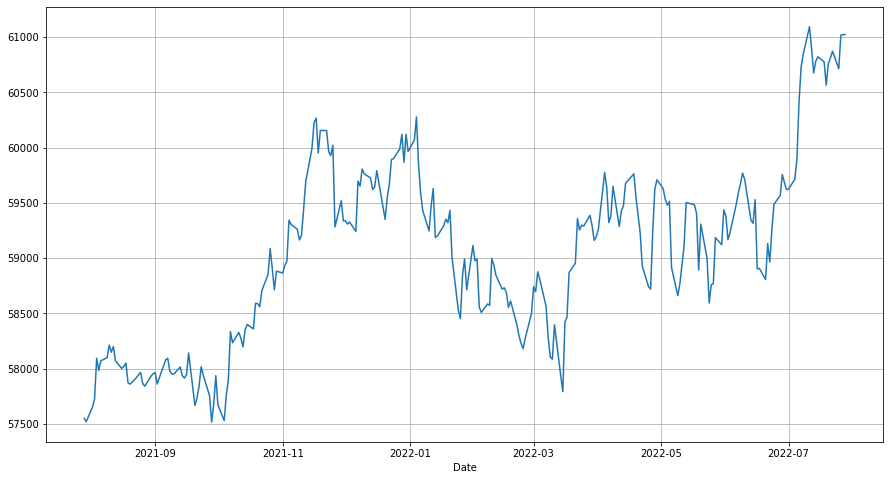

In [10]:
#Get the Portofolio
size=260
portfolio_csv = 'portofolio.csv'
df_meta = pd.read_csv(portfolio_csv ,sep=';').set_index('Code')
df_global = df_cotacoes[:size].apply(lambda x: sum(df_meta['Quantidade'][k]*v*(exchange_rates[x.name] if df_meta['Moeda'][k] == 'USD' else 1) for k,v in x.items()),axis=1)        
df_global[:].plot(figsize=(15,8),grid=True)

In [11]:
start =60
stop = 0
df_global_grow = (df_global / df_global.shift(-1)).dropna()
growth = (df_global.iloc[stop]/df_global.iloc[start]-1)
growth_abs = df_global.iloc[stop] - df_global.iloc[start]
std = df_global_grow.std()
'Growth ABS = {:.2f}, Growth = {:.2%}, STD = {:.6f}, Racio = {:.3f}'.format(growth_abs, growth,std,growth/std)

'Growth ABS = 1510.22, Growth = 2.54%, STD = 0.003595, Racio = 7.059'

In [12]:
df = df_portofolio[df_portofolio['Code']=='LU1548497772']
df

,Code,Nome,Quantidade,Data de subscricao,Cotacao de Subscricao,Moeda,Data da cotacao,cotacao actual,Dias,Rentabilidade anual %,Rentabilidade Absoluta,Valor Actual,Ganho Absoluto
